#RNA example

We take a fasta file in input and write utility functions to build a graph representation based on the structure computed by RNAfold. Finally we use the EDeN vectorizer to perform clustering or build a predictive model.  

In [1]:
%matplotlib inline

set an interface for data acquisition, either from file or from remote 

In [2]:
def rfam_uri(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)

In [ ]:
def rfam_uri(family_id):
    return '%s.fa'%(family_id)

In [3]:
rfam_id = 'RF00005' #tRNA

In [4]:
rfam_id = 'RF00871' #microRNA mir-689

In [5]:
rfam_id = 'RF02275' #Hammerhead_HH9

write a parser for FASTA format

In [8]:
import re
from eden import util

def fasta_to_fasta( input ):
    for m in re.finditer(r"^(>[^\n]+)\n+([^>]+)",'\n'.join(util.read( input )), re.MULTILINE):
        if m: 
            header, seq = m.groups()
            seq = re.sub('\n','',seq)
            yield header
            yield seq

In [9]:
iterable = fasta_to_fasta(rfam_uri(rfam_id))
[line for line in iterable]

['>ABQF01059171.1/305-384',
 'UUGGGCCGUUACCUACAGCUGAUGAGCUCCAAGAAGAGCGAAACCUGCUAAGCAAGGUCCUGUAGUAUUGGCCUGAACCC',
 '>AADN03003451.1/4511-4593',
 'CUGGGCCGUUACCUACAGCUGAUGAGCUCCAAGAAGAGCGAAACCUUGUAAAAUAGGUCCUGUAGUAUUGGCCUGAUGAGCUC',
 '>AAWZ02032198.1/15823-15741',
 'UGAGGCCGUUACCUACAGCUGAUGAGCUCCAAAAAGAGCGAAACCUGUUAAAAUAGGUCCUGUAGUAUUGGCCGACUGAGCCG',
 '>AGAI01055016.1/63287-63205',
 'UUAGGCCGUUACCUACAGCUGAUGAGCUCCAAGAAGAGCGAAACCUUUUAAGAUAGGUCCUGUAGUAUUGGCCUGAAAACCAU',
 '>AANN01066007.1/588-511',
 'CUGAGCCGUUACCUGCAGCUGAUGAGCUCCAAAAAGAGCGAAACCUGCUAGGUCCUGCAGUACUGGCUUAAGAGGCUA',
 '>AAQR03161315.1/4048-3972',
 'UUGAGCCGUUACCUGCAGCUGAUGAGCUCCAAAAAGAGCGAAACCUAUUAGGUCCUGCAGUACUGGCUUAAGAGAAU',
 '>ABRN01375670.1/21703-21777',
 'UUGAGCCGUUACCUGCAGCUGAUGAGCUCCAAAAAGAGCGAAACCUAUUAGGUCCUGCAGUACUGGCUUGAGAUA',
 '>ABRP01270906.1/1966-2043',
 'UUGAGCCGUUACCUGCAGCUGAUGAGCUCCAAAAAGAGCGAAACCUAUUAGGUCCUGCAGUACUGGCUUAAGAUAAUA',
 '>ACTA01058962.1/24761-24837',
 'AUGAGCCGUUACCUGCAGCUGAUGAGCUCCAAAAAGAGCGAAACCUA

write a converter that takes a parsed fasta file in input, calls RNAfold, parses the output and builds a graph

In [11]:
import networkx as nx
def sequence_dotbracket_to_graph(seq_info, seq_struct):
    G = nx.Graph()
    lifo = list()
    for i,(c,b) in enumerate( zip(seq_info, seq_struct) ):
        G.add_node(i, label = c)
        if i > 0:
            #add backbone edges
            G.add_edge(i,i-1, label='-')
        if b == '(':
            lifo.append(i)
        if b == ')':
            #when a closing bracket is found, add a basepair edge with the corresponding opening bracket 
            j = lifo.pop()
            G.add_edge(i,j, label='=')
    return G


import subprocess as sp
def pre_process(input):
    lines =  fasta_to_fasta(input)
    for line in lines:
        #get a header+sequence
        header = line
        seq = lines.next()
        
        #invoke RNAfold
        cmd = 'echo "%s" | RNAfold --noPS' % seq
        out = sp.check_output(cmd, shell = True)
        #parse the output
        text = out.strip().split('\n')
        seq_info = text[0]
        seq_struct = text[1].split()[0]
        #make a graph
        G = sequence_dotbracket_to_graph(seq_info, seq_struct)
        G.graph['id'] = header
        yield G

display the graphs

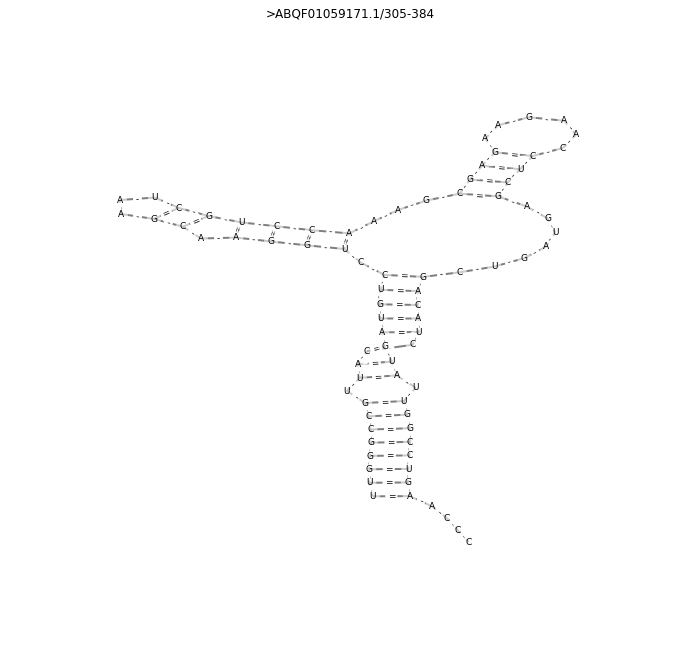

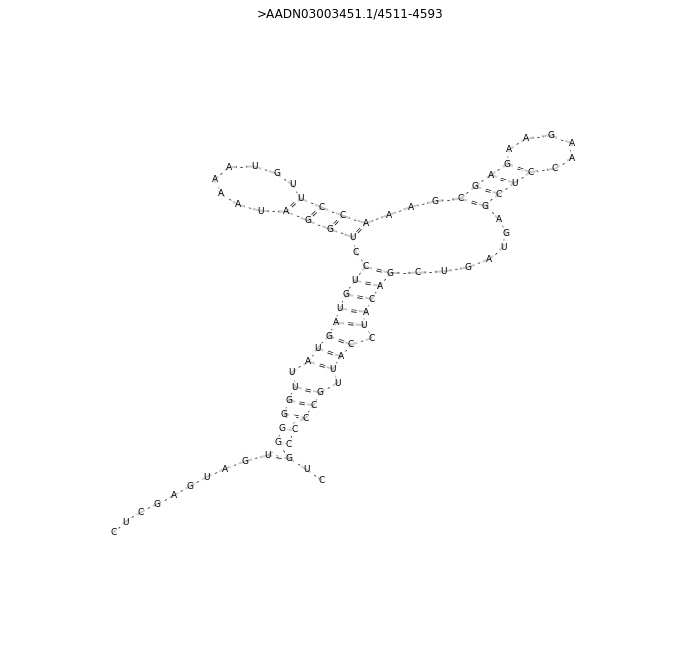

In [13]:
from eden.util.display import draw_graph
import itertools

graphs = pre_process(rfam_uri(rfam_id))

for graph in itertools.islice(graphs,2):
    draw_graph(graph, size=11, node_size=200, node_border=False)

Setup the vectorizer object

In [14]:
from eden.graph import Vectorizer
vectorizer = Vectorizer( r=2, d=2 )

In [15]:
def describe(X):
    print 'Instances: %d ; Features: %d with an avg of %d features per instance' % (X.shape[0], X.shape[1],  X.getnnz()/X.shape[0])

process the fasta, build the graphs, transform them with the vectorizer into sparse vectors

In [16]:
graphs = pre_process(rfam_uri(rfam_id))
Xp = vectorizer.transform( graphs, n_jobs=1 )
describe(Xp)

Instances: 33 ; Features: 1048577 with an avg of 551 features per instance


create a custom fasta parser that shuffles the sequences; these will be used as negative examples 

In [17]:
import random
def shuffle_fasta( input , times=1, order=1):
    iterable = fasta_to_fasta(input)
    for line in iterable:
        #get pairs of header-sequence
        header = line
        seq = iterable.next()
        #shuffle
        for i in range(times):
            #split the seqeunce in substrings of length 'order'
            kmers = [ seq[i:i+order] for i in range(0,len(seq),order) ]
            #shuffle and join
            random.shuffle(kmers)
            seq_out = ''.join(kmers)
            yield header
            yield seq_out

In [18]:
iterable = shuffle_fasta( rfam_uri(rfam_id), times=2, order=2)
graphs = pre_process( iterable )
Xn = vectorizer.transform( graphs, n_jobs=1 )
describe(Xn)

Instances: 66 ; Features: 1048577 with an avg of 546 features per instance


build a data matrix by stacking the data matrix for positive and for negative instances, build a target vector with +1 for positive ids and -1 for negative ids

In [19]:
import numpy as np
from scipy.sparse import vstack

yp =  [1] * Xp.shape[0]
yn = [-1] * Xn.shape[0]
y = np.array(yp + yn)
X = vstack( [Xp,Xn] , format = "csr")

fit a binary classifier from the scikit ML library

In [20]:
from sklearn.linear_model import SGDClassifier
estimator = SGDClassifier(class_weight='auto', shuffle = True )
estimator.fit(X,y)

SGDClassifier(alpha=0.0001, class_weight='auto', epsilon=0.1, eta0=0.0,
       fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
       loss='hinge', n_iter=5, n_jobs=1, penalty='l2', power_t=0.5,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

evaluate the quality of the classifier using the cross-validation technique 

In [21]:
from sklearn import cross_validation
print 'Predictive performance:'
#assess the generalization capacity of the model via a k-fold cross validation
for scoring in ['accuracy','precision', 'recall', 'f1', 'average_precision', 'roc_auc']:
    scores = cross_validation.cross_val_score( estimator, X, y, cv = 3, scoring = scoring )
    print( '%20s: %.3f +- %.3f' % ( scoring, np.mean( scores ), np.std( scores ) ) )

Predictive performance:
            accuracy: 1.000 +- 0.000
           precision: 1.000 +- 0.000
              recall: 1.000 +- 0.000
                  f1: 1.000 +- 0.000
   average_precision: 1.000 +- 0.000
             roc_auc: 1.000 +- 0.000


use the decision_function of the classifier to get an indication on its confidence for each instance 

In [22]:
graphs = pre_process(rfam_uri(rfam_id))
Xp = vectorizer.transform( graphs, n_jobs=1 )
predictions = estimator.decision_function(Xp)

iterable = fasta_to_fasta(rfam_uri(rfam_id))
headers = [line for line in itertools.islice(iterable, 0, None, 2)]

for prediction,header in sorted(zip(predictions, headers), reverse=True):
    print "Score: %0.3f  %s " % (prediction, header)

Score: 6.685  >AALT01643156.1/444-367 
Score: 6.497  >AAHX01036414.1/22499-22433 
Score: 6.446  >AGCE01141575.1/4443-4377 
Score: 6.287  >ABQF01059171.1/305-384 
Score: 6.228  >AL773539.18/161561-161627 
Score: 5.837  >AEKR01154328.1/10424-10501 
Score: 5.823  >AGTP01043633.1/33547-33613 
Score: 5.821  >ACTA01058962.1/24761-24837 
Score: 5.780  >AFYH01089550.1/2099-2023 
Score: 5.766  >AEYP01022184.1/5895-5972 
Score: 5.748  >ABRN01375670.1/21703-21777 
Score: 5.711  >AFTD01093388.1/13316-13239 
Score: 5.647  >AANN01066007.1/588-511 
Score: 5.603  >AAQR03161315.1/4048-3972 
Score: 5.570  >AFEY01454121.1/10166-10232 
Score: 5.516  >ABRP01270906.1/1966-2043 
Score: 5.470  >AAKN02030441.1/10428-10505 
Score: 5.320  >AAGU03018532.1/57571-57497 
Score: 5.248  >AGAI01055016.1/63287-63205 
Score: 5.171  >ABRQ01056532.1/2019-2096 
Score: 5.077  >AAFR03027197.1/99742-99816 
Score: 5.076  >AAQQ01544543.1/2644-2721 
Score: 4.997  >AADN03003451.1/4511-4593 
Score: 4.900  >AAWZ02032198.1/15823-1574

In [23]:
%%time
from sklearn.cluster import KMeans

kmeans = KMeans( n_clusters=4 )
predictions = kmeans.fit_predict(Xp)

#get the headers of the FASTA files
iterable = fasta_to_fasta(rfam_uri(rfam_id))
headers = [line for line in itertools.islice(iterable, 0, None, 2)]

for prediction,header in sorted(zip(predictions, headers)):
    print "cluster: %d   %s " % (prediction, header)

cluster: 0   >AAIY01498693.1/2014-1937 
cluster: 0   >AALT01643156.1/444-367 
cluster: 0   >AAPN01231077.1/15198-15121 
cluster: 1   >AAGU03018532.1/57571-57497 
cluster: 1   >AAHX01036414.1/22499-22433 
cluster: 1   >AAKN02030441.1/10428-10505 
cluster: 1   >AANN01066007.1/588-511 
cluster: 1   >AAQQ01544543.1/2644-2721 
cluster: 1   >AAQR03161315.1/4048-3972 
cluster: 1   >ABRN01375670.1/21703-21777 
cluster: 1   >ABRP01270906.1/1966-2043 
cluster: 1   >ABRQ01056532.1/2019-2096 
cluster: 1   >ACTA01058962.1/24761-24837 
cluster: 1   >AEKR01154328.1/10424-10501 
cluster: 1   >AEYP01022184.1/5895-5972 
cluster: 1   >AFTD01093388.1/13316-13239 
cluster: 1   >AGCE01141575.1/4443-4377 
cluster: 1   >AGTP01043633.1/33547-33613 
cluster: 1   >AL773539.18/161561-161627 
cluster: 2   >AADN03002802.1/91438-91372 
cluster: 2   >AAFR03027197.1/99742-99816 
cluster: 2   >AAWR02025218.1/31065-31139 
cluster: 2   >ABQF01023900.1/7348-7414 
cluster: 2   >ABQO010129822.1/1187-1253 
cluster: 2   >ACIV

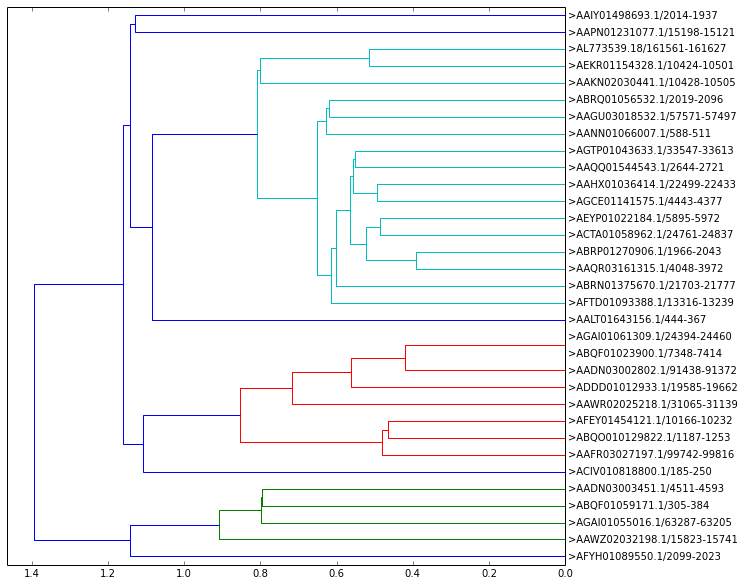

In [24]:
graphs = itertools.islice( pre_process( rfam_uri( rfam_id ) ), 50 )
from eden.util.display import dendrogram
dendrogram( graphs, vectorizer )

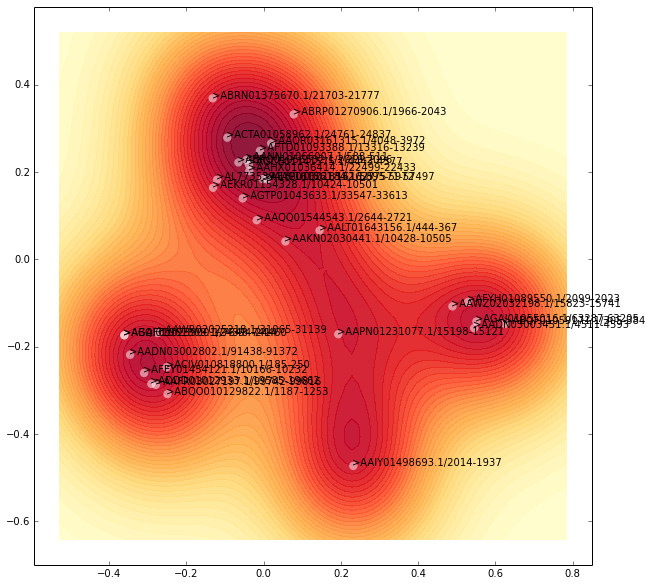

CPU times: user 1.55 s, sys: 86.1 ms, total: 1.63 s
Wall time: 1.95 s


In [25]:
%%time
graphs = itertools.islice( pre_process( rfam_uri( rfam_id ) ), 50 )
from eden.util.display import embed2D
embed2D( graphs, vectorizer )